# Company Snapshot

In [76]:
!pip install yahoo_fin





[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import datetime
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday
import pandas as pd

# Define Indian Business Day
class IndiaBusinessDay(AbstractHolidayCalendar):
    rules = [
        Holiday("Republic Day", month=1, day=26, observance=nearest_workday),
        Holiday("Independence Day", month=8, day=15, observance=nearest_workday),
        Holiday("Gandhi Jayanti", month=10, day=2, observance=nearest_workday),
        # Add more Indian holidays as needed
    ]

indian_busday = CustomBusinessDay(calendar=IndiaBusinessDay())

# Example usage:
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 12, 31)

indian_business_days = pd.date_range(start=start_date, end=end_date, freq=indian_busday)

# Continue with the rest of your code...
# Add your stock analysis, data fetching, or any other operations using indian_business_days
# ...

# For example, printing the generated business days
print(indian_business_days)


DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12',
               ...
               '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
               '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=259, freq='C')


In [61]:
#  Symbol
symbol = 'PAYTM.NS'
market_symbol = 'PAYTM.NS'

In [62]:
def get_biz_days_delta_date(start_date_str, delta_days):
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = start_date + (delta_days * indian_busday)
    end_date_str = datetime.datetime.strftime(end_date, "%Y-%m-%d")
    return end_date_str

In [63]:
def load_price_data(symbol, start_date, end_date):
    # Download data
    try:
        df = si.get_data(symbol, start_date=start_date, end_date=end_date, index_as_date=False)
        return df
    except:
        print('Error loading stock data for ' + symbol)
        return None
    
today = datetime.datetime.today()
today_str = today.strftime("%Y-%m-%d")
past_date_str = get_biz_days_delta_date(today_str, -251)
df = load_price_data(symbol, past_date_str,today_str)  
market_df = load_price_data(market_symbol, past_date_str,today_str) 
print(market_df)

          date        open        high         low       close    adjclose   
0   2023-02-14  653.900024  654.700012  636.650024  642.700012  642.700012  \
1   2023-02-15  638.000000  650.000000  633.349976  640.049988  640.049988   
2   2023-02-16  640.000000  650.000000  623.500000  628.900024  628.900024   
3   2023-02-17  629.000000  639.900024  620.650024  626.849976  626.849976   
4   2023-02-20  624.750000  633.599976  621.099976  630.500000  630.500000   
..         ...         ...         ...         ...         ...         ...   
234 2024-01-29  763.950012  768.900024  747.049988  752.049988  752.049988   
235 2024-01-30  753.000000  767.000000  753.000000  761.099976  761.099976   
236 2024-01-31  758.150024  774.299988  753.099976  761.200012  761.200012   
237 2024-02-01  609.000000  609.000000  609.000000  609.000000  609.000000   
238 2024-02-02  487.200012  487.200012  487.200012  487.200012  487.200012   

      volume    ticker  
0    4115771  PAYTM.NS  
1    2300566 

In [64]:
def plot_market_graph(market_symbol, in_df):
    df = in_df.copy()
   
    fig = make_subplots(rows=1, cols=1,
                        subplot_titles=['Close'])

    #  Plot close price
    fig.add_trace(go.Line(x=df.index, y=df['close'], line=dict(color="blue", width=1), name="Close"), row=1, col=1)
    
    fig.update_layout(
        title={'text': market_symbol, 'x': 0.5},
        autosize=True,)
    fig.update_yaxes(range=[0, 1000000000], secondary_y=True)
    fig.update_yaxes(visible=False, secondary_y=True)  # hide range slider

    #  Save output
    fig.show()

In [65]:
def plot_stock_graph(symbol, in_df):
    df = in_df.copy()
    #  Calculate strategy indicators
    df.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
    df['RSI'] = ta.rsi(df['close'], length=14)
    indicator_bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['BB_mid'] = indicator_bb.bollinger_mavg()
    df['BB_high'] = indicator_bb.bollinger_hband()
    df['BB_low'] = indicator_bb.bollinger_lband()
    indicator_keltner = KeltnerChannel(high=df['high'], low=df['low'], close=df['close'], window=20)
    df['Keltner_mid'] = indicator_keltner.keltner_channel_mband()
    df['Keltner_high'] = indicator_keltner.keltner_channel_hband()
    df['Keltner_low'] = indicator_keltner.keltner_channel_lband()
   
    fig = make_subplots(rows=5, cols=1,
                        subplot_titles=['Close', 'MACD', 'RSI', 'Bollinger Bands', 'Keltner Channels',])

    #  Plot close price
    fig.add_trace(go.Line(x=df.index, y=df['close'], line=dict(color="blue", width=1), name="Close"), row=1, col=1)

    # Plot MACD
    fig.add_trace(go.Line(x=df.index, y=df['MACD_12_26_9'], line=dict(color="#99b3ff", width=1), name="MACD"), row=2,
                  col=1)
    fig.add_trace(go.Line(x=df.index, y=df['MACDs_12_26_9'], line=dict(color="#ebab34", width=1), name="MACD"), row=2,
                  col=1)

    # Plot RSI
    fig.add_trace(go.Line(x=df.index, y=df['RSI'], line=dict(color="#99b3ff", width=1), name="RSI"), row=3, col=1)
    fig.add_hline(y=30, line=dict(color="#ebab34", width=1), row=3, col=1)
    fig.add_hline(y=70, line=dict(color="#ebab34", width=1), row=3, col=1)

    # Plot Bollinger
    fig.add_trace(go.Line(x=df.index, y=df['close'], line=dict(color="blue", width=1), name="Close"), row=4, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['BB_high'], line=dict(color="#ebab34", width=1), name="BB High"), row=4, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['BB_mid'], line=dict(color="#fac655", width=1), name="BB Mid"), row=4, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['BB_low'], line=dict(color="#ebab34", width=1), name="BB Low"), row=4, col=1)

    # Plot Keltner
    fig.add_trace(go.Line(x=df.index, y=df['close'], line=dict(color="blue", width=1), name="Close"), row=5, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['Keltner_high'], line=dict(color="#ebab34", width=1), name="Keltner High"),
                  row=5, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['Keltner_mid'], line=dict(color="#fac655", width=1), name="Keltner Mid"),
                  row=5, col=1)
    fig.add_trace(go.Line(x=df.index, y=df['Keltner_low'], line=dict(color="#ebab34", width=1), name="Keltner Low"),
                  row=5, col=1)

    fig.update_layout(
        title={'text': symbol, 'x': 0.5},
        autosize=False, width= 800, height= 1600)
    fig.update_yaxes(range=[0, 1000000000], secondary_y=True)
    fig.update_yaxes(visible=False, secondary_y=True)  # hide range slider

    #  Save output
    fig.show()


In [66]:
yf_symbol = yf.Ticker(symbol)

# Print company info
company_info = yf_symbol.info
#company_info_obj = json.loads(employee_string)
# Print company info
company_info = yf_symbol.info
# company_info_obj = json.loads(employee_string)
print("Company Name:", company_info.get("longName", "N/A"))
print("Business Summary:", company_info.get("longBusinessSummary", "N/A"))
print("Website:", company_info.get("website", "N/A"))
print("Industry:", company_info.get("industry", "N/A"))
print("Current price:", company_info.get("currentPrice", "N/A"))

# Check if 'totalRevenue' key is present before accessing it
total_revenue = company_info.get("totalRevenue")
print("Total revenue:", locale.format_string("%d", total_revenue, grouping=True) if total_revenue is not None else "N/A")

# Check if 'grossProfits' key is present before accessing it
gross_profits = company_info.get("grossProfits")
print("Gross profits:", locale.format_string("%d", gross_profits, grouping=True) if gross_profits is not None else "N/A")


# Check for other keys
print("Revenue growth: ",company_info.get("revenueGrowth"))  
print("Earnings growth:", company_info.get("earningsGrowth", "N/A"))
print("Profit margins:", company_info.get("profitMargins", "N/A"))
print("Debt to equity:", company_info.get("debtToEquity", "N/A"))
print("Return on equity:", company_info.get("returnOnEquity", "N/A"))
print("Quick ratio:", company_info.get("quickRatio", "N/A"))
print("52-Week high: ",company_info.get("fiftyTwoWeekHigh"))      
print("52-Week low: ",company_info.get("fiftyTwoWeekLow")) 

Company Name: One97 Communications Limited
Business Summary: One97 Communications Limited provides payment, commerce and cloud, and financial services to consumers and merchants in India. The company provides payment and financial services, which primarily includes payment facilitator services, facilitation of consumer and merchant lending to consumers and merchants, wealth management, etc. It also offers commerce and cloud services, including aggregator for digital products; ticketing services for travel and entertainment; and providing voice and messaging platforms to the telecom operators, enterprise customers, and other businesses, etc. In addition, the company provides consumers a range of instruments, both third party like cards, net banking, and Paytm payment instruments, such as wallet, Paytm postpaid to make online payments using the Paytm app; and make online payments on third party apps and in-store payments through QR codes and devices. Further, it offers mobile banking, le

/home/tikam/stock-market/env3/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




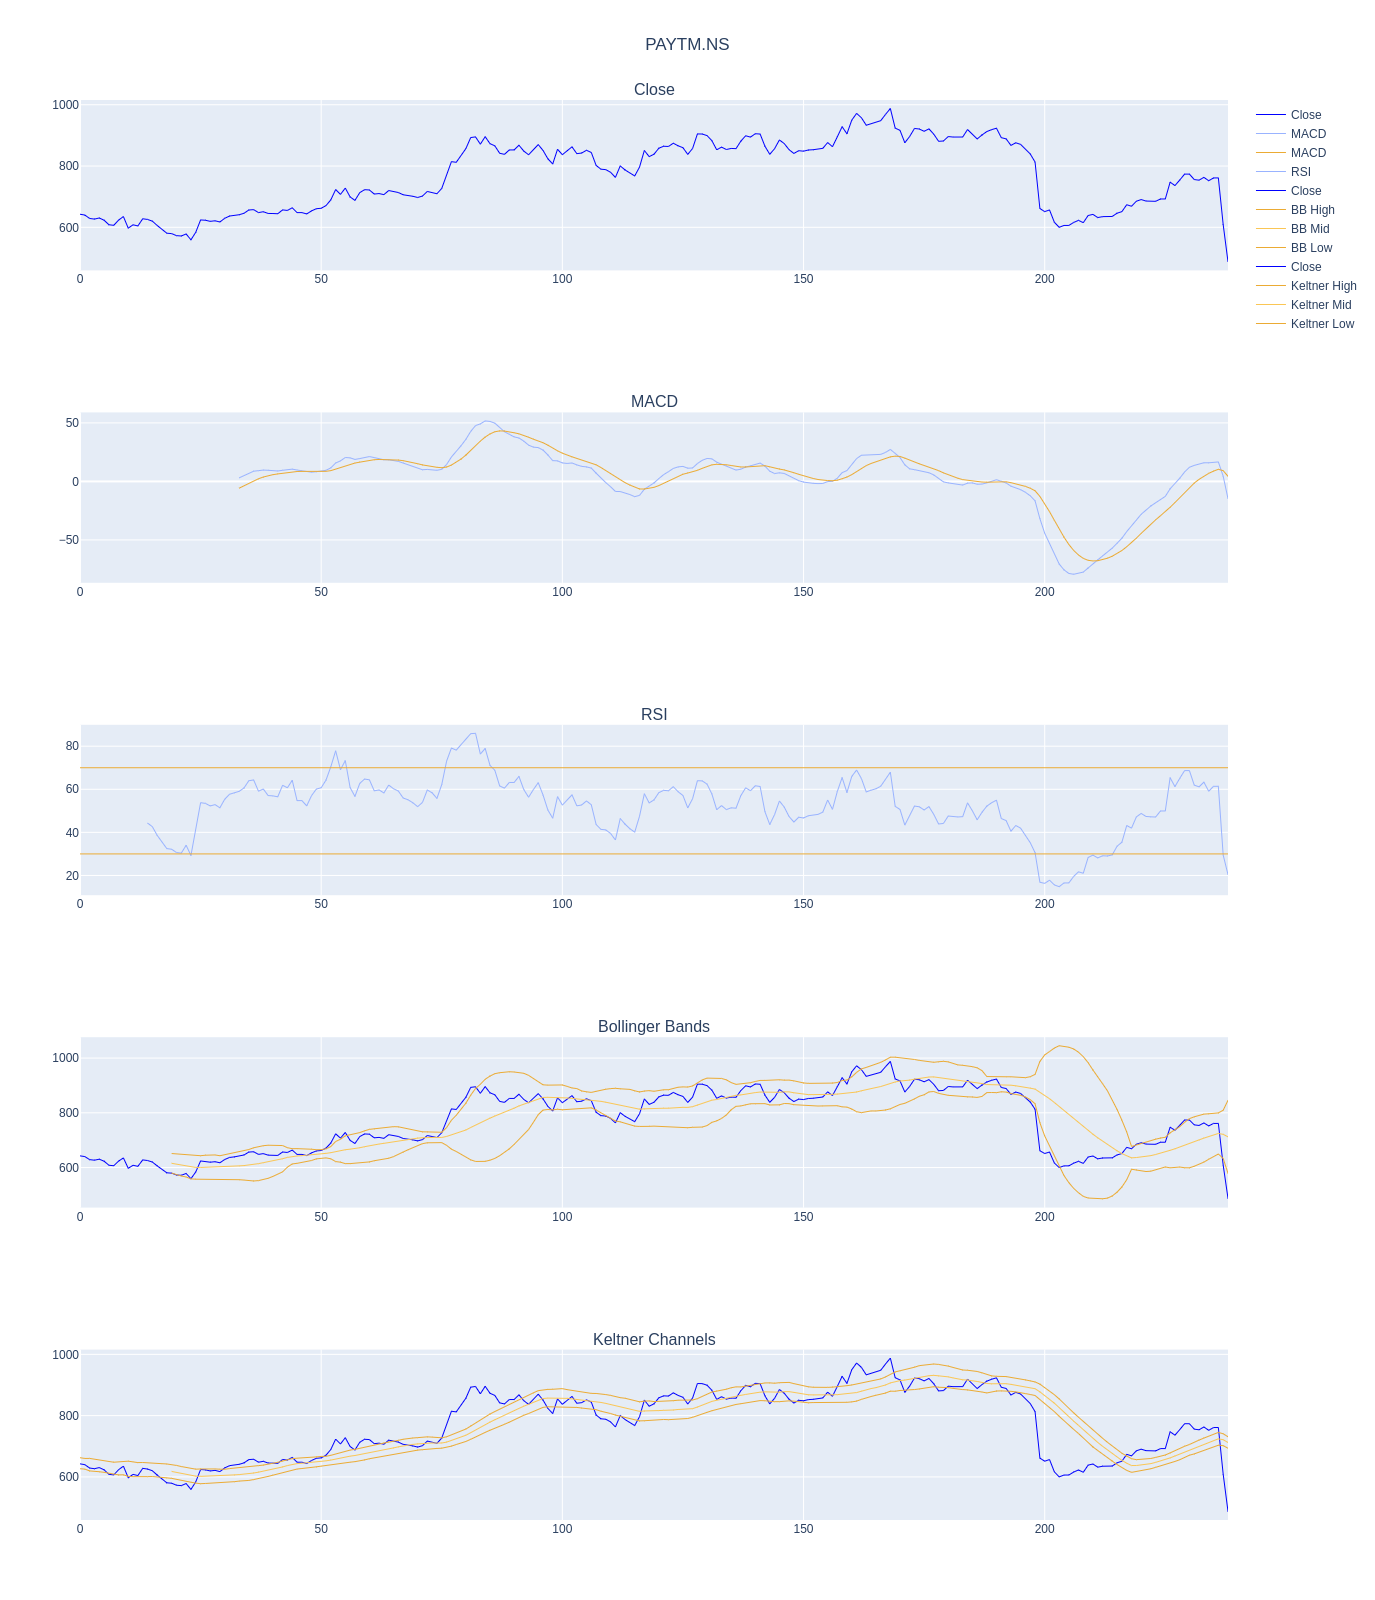

In [67]:
#  Plot stock graph and TAs
plot_stock_graph(symbol, df)


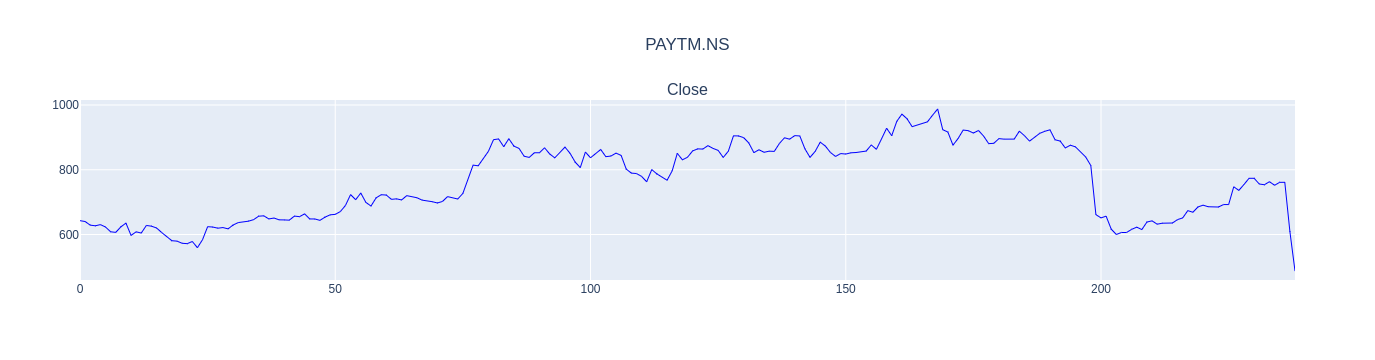

In [68]:
#  Plot market graph
plot_market_graph(market_symbol, market_df)

In [74]:
def retrieve_google_news(symbol, past_days):
    googlenews = GoogleNews(period=f"{past_days}d")
    googlenews.clear()
    googlenews.search(symbol)
    result = googlenews.result()
    df = pd.DataFrame(result)
    return df

In [75]:
#  Retrieve Google News
news_df = retrieve_google_news(symbol, 5)

for index, row in news_df.iterrows():
    print(f"-- {row['title']} --\n{row['desc']}\n\n")

-- Results Review for ITC, State Bank of India, Berger Paints, Tata Elxsi, Thermax --





In [71]:
from GoogleNews import GoogleNews
import pandas as pd

def retrieve_google_news(symbol, past_days):
    googlenews = GoogleNews(period=f"{past_days}d")
    googlenews.clear()
    googlenews.search(symbol)
    result = googlenews.result()
    df = pd.DataFrame(result)
    return df

# Example usage:
symbol = "SBIN.NS"  # Replace with your desired stock symbol
news_df = retrieve_google_news(symbol, 5)

for index, row in news_df.iterrows():
    print(f"-- {row['title']} --\n{row['desc']}\n\n")


-- Results Review for ITC, State Bank of India, Berger Paints, Tata Elxsi, Thermax --





In [79]:
import requests
from bs4 import BeautifulSoup

symbol = "AAPL"  # Replace with your desired stock symbol

# URL for Yahoo Finance news page for the specified stock symbol
url = f"https://finance.yahoo.com/quote/{symbol}/news?p={symbol}"

# Send a GET request to the URL with allow_redirects=True
response = requests.get(url, allow_redirects=True)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract news headlines and summaries
    headlines = soup.find_all("h3", class_="Mb(5px)")
    summaries = soup.find_all("p", class_="fz(14px)")

    # Print the headlines and summaries
    for headline, summary in zip(headlines, summaries):
        print(f"-- {headline.text.strip()} --\n{summary.text.strip()}\n\n")
else:
    print(f"Failed to fetch news. Status code: {response.status_code}")


Failed to fetch news. Status code: 404
